In [1]:
# paraPropPython time-dependent signal example use of paraPropPython.py notebook
# s. prohira, c. sbrocco
import sys
sys.path.append('../')
%matplotlib inline
import paraPropPython as ppp
from receiver import receiver
import numpy as np
import matplotlib.pyplot as plt
import util as util
import time

In [2]:
##### time-dependent example #####

### first, initialize an instance of paraProp by defining its dimensions and frequency of interest ###
iceDepth = 60. # m
iceLength = 110. # m
dx = 1 # m
dz = 0.05 # m

freq = 0.2

### it is useful to set the reference depth as the source depth when you only have one transmitter ###
sourceDepth = 10. # m
sim = ppp.paraProp(iceLength, iceDepth, dx, dz, refDepth=1, airHeight=1)

### useful arrays for plottinng ###
z = sim.get_z()
x = sim.get_x()

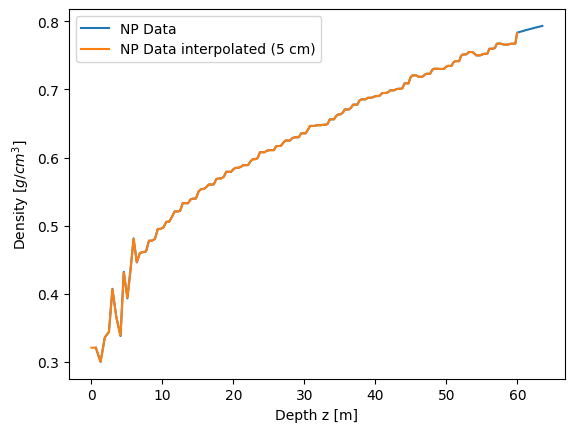

In [3]:
### NOTE: define n before defining source ###
def get_profile_from_file(fname):
    profile_data = np.genfromtxt(fname)
    z_profile = profile_data[:,0]
    n_profile = profile_data[:,1]
    return n_profile, z_profile

### an example of defining n as a function of z (also can be done using a vector, see implementation) ###
rho_vec0, z_vec0 = get_profile_from_file('NP_data_dzb.txt')
rho_vec0 = rho_vec0/1e3

A0 = 1.0
B0 = 0.841
def rho2refindex(rho, A, B):
    return A + B * rho

z_vec = np.arange(0, iceDepth, dz)
rho_vec = np.interp(z_vec, z_vec0, rho_vec0)

n_vec = rho2refindex(rho_vec, A0, B0)


plt.plot(z_vec0, rho_vec0,label='NP Data')
plt.plot(z_vec, rho_vec,label='NP Data interpolated (5 cm)')
plt.ylabel(r'Density [$g/cm^{3}$]')
plt.xlabel('Depth z [m]')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


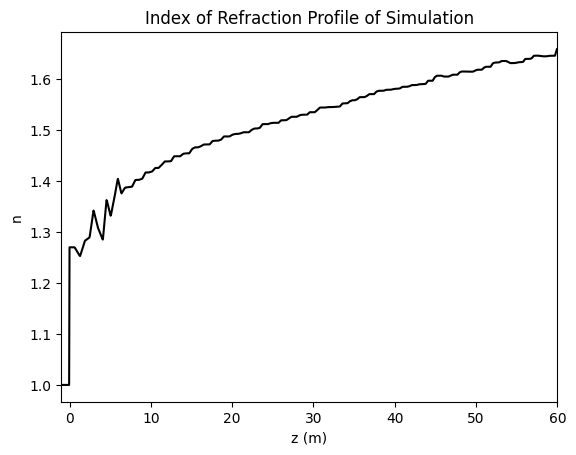

In [4]:
sim.set_n(nVec=n_vec, zVec=z_vec)

### plot ###
plt.plot(z, sim.get_n()[:,0], color='black')
plt.ylabel('n')
plt.xlabel('z (m)')
plt.title('Index of Refraction Profile of Simulation')
plt.xlim(z[0], z[-1])

plt.show()

/home/aliarish459/paraprop/ParapRop/paraPropPython-master/paraPropPython.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  nPoints = int((centerLmbda0/2) / self.dz)


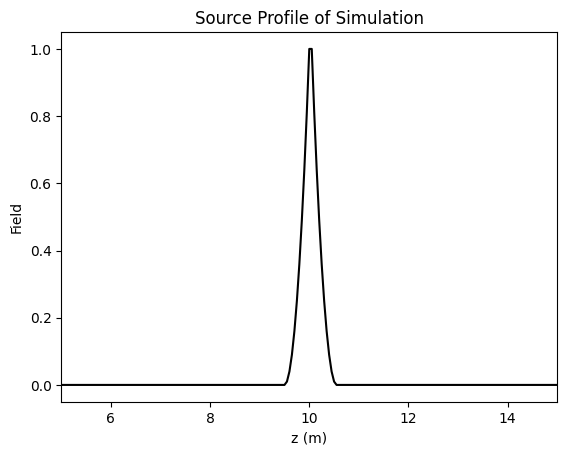

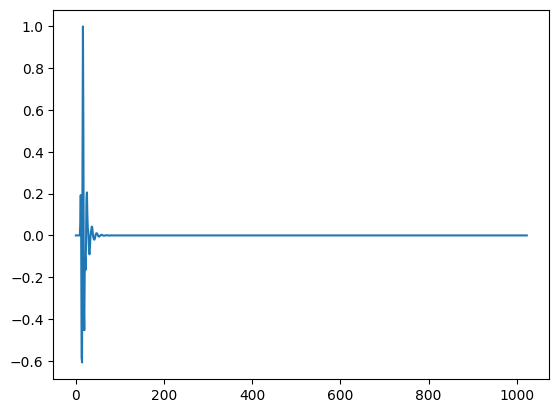

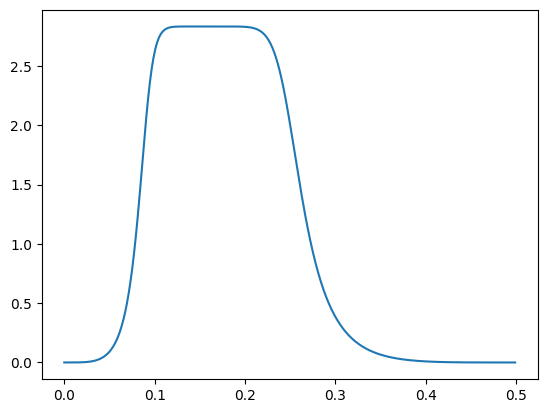

In [5]:
### an example of defining the source as a dipole ###
### (also can be done using a vector or function like n, see implementation) ###
sim.set_dipole_source_profile(freq, sourceDepth)

### plot, zoomed in ###
plt.plot(z, abs(sim.get_source_profile()), color='black')
plt.ylabel('Field')
plt.xlabel('z (m)')
plt.title('Source Profile of Simulation')
plt.xlim(sourceDepth - 5, sourceDepth + 5)
plt.show()


### set a td signal ###
dt = 1
impulse = np.zeros(2**10, dtype='complex')
impulse[10] = 1+0j
sig = util.normToMax(util.butterBandpassFilter(impulse, 0.09, 0.25, 1/dt, 4))
sim.set_td_source_signal(sig, dt)

t = sim.get_time()
f = sim.get_frequency()
A = sim.get_spectrum()
plt.plot(t, sig.real)
plt.show()
plt.plot(f, abs(A))
plt.show()


In [7]:
rxList = [receiver(30, 15)]
tic = time.perf_counter()
### run the solver ###
sim.do_solver(rxList)
toc = time.perf_counter()
print(f"Simulation ran in: {toc-tic:0.4} seconds")

Simulation ran in: 7.951 seconds


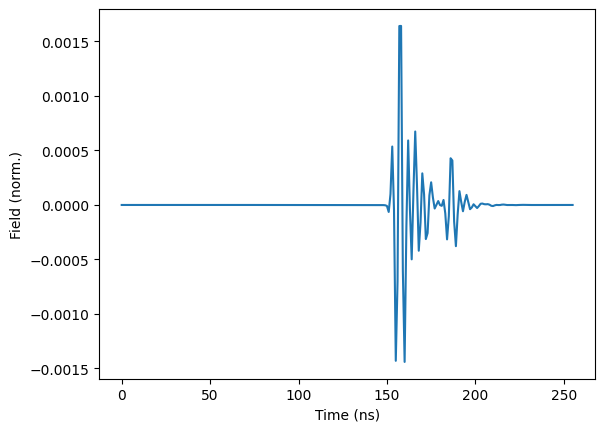

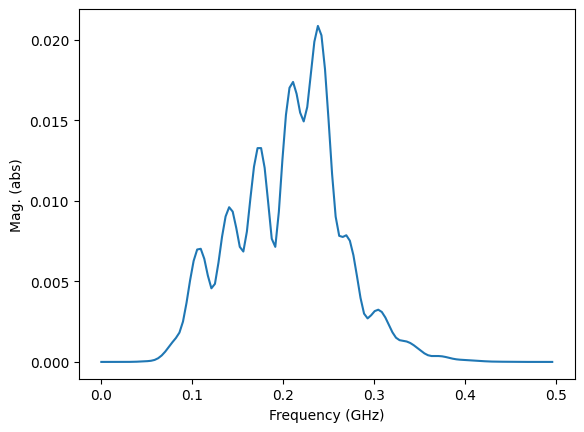

In [8]:
rx = rxList[0]
t = rx.get_time()
sig = rx.get_signal().real
f = rx.get_frequency()
spec = rx.get_spectrum()

#wrapped = np.roll(sig, -np.argmax(sig)+45)
plt.plot(t, sig)
plt.xlabel("Time (ns)")
plt.ylabel("Field (norm.)")
#plt.savefig("RX_841.pdf")
plt.show()
plt.plot(f, abs(spec)) 
plt.xlabel("Frequency (GHz)")
plt.ylabel("Mag. (abs)")
#plt.xlim(0,0.5)
plt.show()



In [6]:
#Simulation Geometry
iceDepth = 60. # m
iceLength = 110. # m
dx = 1 # m
dz = 0.05 # m

#Frequency
freq = 0.2

#Tx and Rx
sourceDepth0 = 10. # m
sourceDepth1 = 20. # m
sourceDepth2 = 50. # m
receiverL0 = 30.
receiverL1 = 100.
receiverDepth0 = 10.
receiverDepth1 = 20.
receiverDepth2 = 50.
receiverRange = [receiverL0, receiverL1]
sourceDepth= [sourceDepth0,sourceDepth1,sourceDepth2]
receiverDepth = [receiverDepth0,receiverDepth1,receiverDepth2]
#Signal Properties
### set a td signal ###

#Refractive Index
### NOTE: define n before defining source ###
def get_profile_from_file(fname):
    profile_data = np.genfromtxt(fname)
    z_profile = profile_data[:,0]
    n_profile = profile_data[:,1]
    return n_profile, z_profile


def get_rx_pulse(z_vec, n_vec, z_tx=sourceDepth, x_rx=receiverRange, z_rx=receiverDepth):
    dt = 1
    impulse = np.zeros(2**8, dtype='complex')
    impulse[10] = 1+0j
    sig = util.normToMax(util.butterBandpassFilter(impulse, 0.09, 0.25, 1/dt, 4))

    sim = ppp.paraProp(iceLength, iceDepth, dx, dz, refDepth=1, airHeight=1)
    sim.set_n(nVec=n_vec, zVec=z_vec)
    sim.set_dipole_source_profile(freq, z_tx)
    sim.set_td_source_signal(sig, dt)
    rxList = [receiver(x_rx, z_rx)]
    ### run the solver ###
    sim.do_solver(rxList)
    rx = rxList[0]
    t = rx.get_time()
    sig_rx = rx.get_signal().real
    f = rx.get_frequency()
    spec_rx = rx.get_spectrum()
    return sig_rx, t, spec_rx, f
def rho2refindex(rho, A, B):
    return A + B * rho

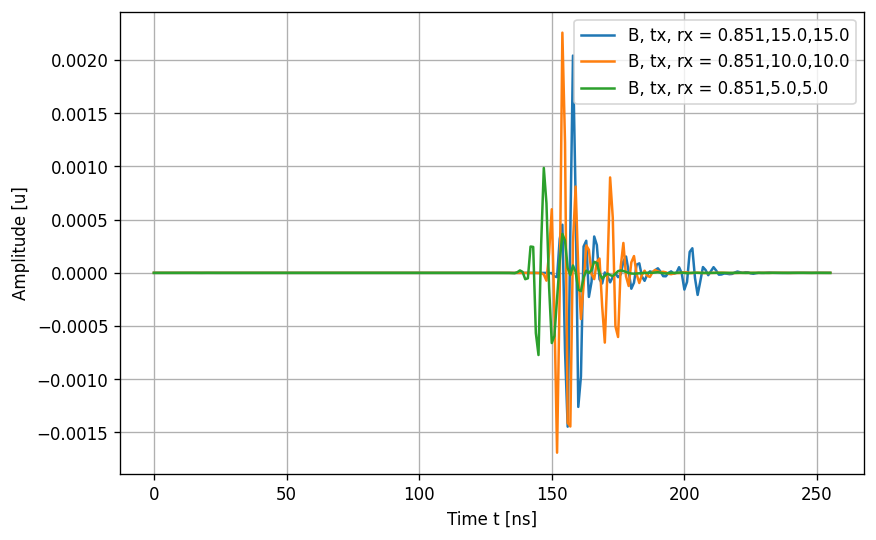

In [19]:
### an example of defining n as a function of z (also can be done using a vector, see implementation) ###
rho_vec0, z_vec0 = get_profile_from_file('NP_data_dzb.txt')
rho_vec0 = rho_vec0/1e3
A0 = 1.0
B1 = 0.840
B2 = 0.841
B3 = 0.851

def rho2refindex(rho, A, B):
    return A + B * rho

z_vec = np.arange(0, iceDepth, dz)
rho_vec = np.interp(z_vec, z_vec0, rho_vec0)
n_vec1 = rho2refindex(rho_vec, A0, B1)
n_vec2 = rho2refindex(rho_vec, A0, B2)
n_vec3 = rho2refindex(rho_vec, A0, B3)
n_vec_list = [n_vec1, n_vec2, n_vec3]
B_list = [B1, B2, B3]

fig = plt.figure(figsize=(8,5),dpi=120)
ax = fig.add_subplot(111)
for i in range(len(n_vec_list)):
    n_vec = n_vec_list[2]
    sig_rx, t, spec_rx, f = get_rx_pulse(z_vec, n_vec, z_tx=sourceDepth[i], x_rx=receiverRange, z_rx=receiverDepth[i])
    ax.plot(t, sig_rx,label='B, tx, rx = ' + str(B_list[2]) + "," + str(sourceDepth[i]) + "," + str(receiverDepth[i]) )
ax.legend()
ax.set_ylabel('Amplitude [u]')
ax.set_xlabel('Time t [ns]')
ax.grid()
#plt.savefig("tx=rx_multiple.pdf")
plt.show()

/home/aliarish459/paraprop/ParapRop/paraPropPython-master/paraPropPython.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  nPoints = int((centerLmbda0/2) / self.dz)


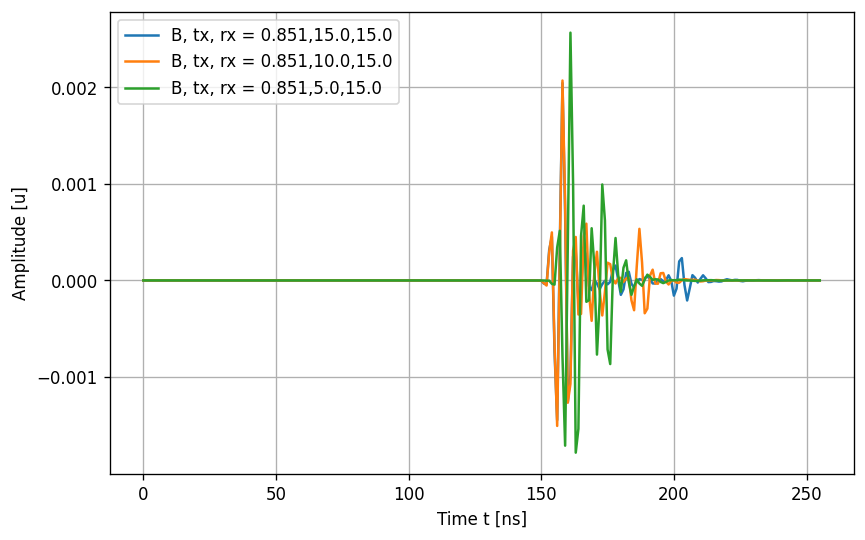

In [21]:
### an example of defining n as a function of z (also can be done using a vector, see implementation) ###
rho_vec0, z_vec0 = get_profile_from_file('NP_data_dzb.txt')
rho_vec0 = rho_vec0/1e3
A0 = 1.0
B1 = 0.840
B2 = 0.841
B3 = 0.851

def rho2refindex(rho, A, B):
    return A + B * rho

z_vec = np.arange(0, iceDepth, dz)
rho_vec = np.interp(z_vec, z_vec0, rho_vec0)
n_vec1 = rho2refindex(rho_vec, A0, B1)
n_vec2 = rho2refindex(rho_vec, A0, B2)
n_vec3 = rho2refindex(rho_vec, A0, B3)
n_vec_list = [n_vec1, n_vec2, n_vec3]
B_list = [B1, B2, B3]

fig = plt.figure(figsize=(8,5),dpi=120)
ax = fig.add_subplot(111)
for i in range(len(n_vec_list)):
    n_vec = n_vec_list[2]
    sig_rx, t, spec_rx, f = get_rx_pulse(z_vec, n_vec, z_tx=sourceDepth[i], x_rx=receiverRange, z_rx=receiverDepth[0])
    ax.plot(t, sig_rx,label='B, tx, rx = ' + str(B_list[2]) + "," + str(sourceDepth[i]) + "," + str(receiverDepth[0]) )
ax.legend()
ax.set_ylabel('Amplitude [u]')
ax.set_xlabel('Time t [ns]')
ax.grid()
#plt.savefig("DiffTx_SameRx.pdf")
plt.show()

/home/aliarish459/paraprop/ParapRop/paraPropPython-master/paraPropPython.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  nPoints = int((centerLmbda0/2) / self.dz)


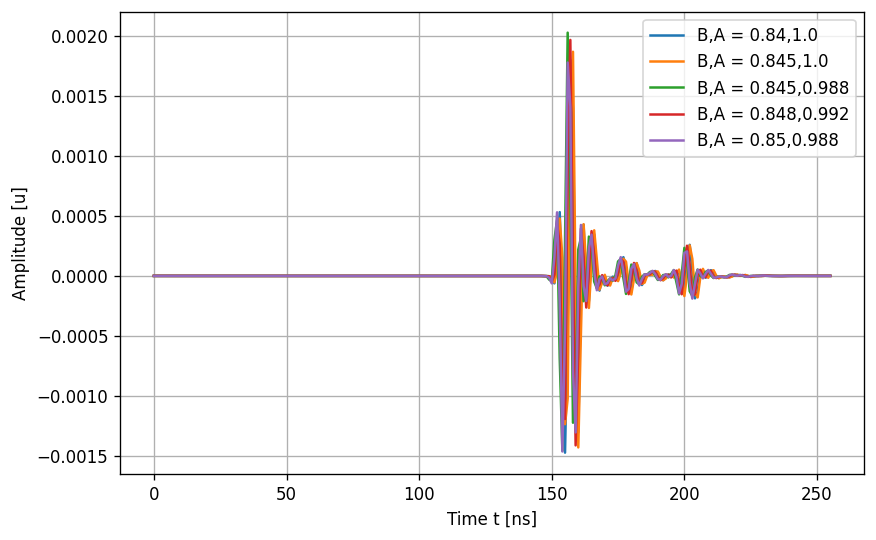

In [22]:
A1 = 1.0
A2 = .988
A3= .992

B1 = 0.840
B2 = 0.845
B3 = 0.850
B4 = .848
B5 = np.sqrt(.508)
def rho2refindex(rho, A, B):
    return A + B * rho

z_vec = np.arange(0, iceDepth, dz)
rho_vec = np.interp(z_vec, z_vec0, rho_vec0)
n_vec1 = rho2refindex(rho_vec, A1, B1)
n_vec2 = rho2refindex(rho_vec, A1, B2)
n_vec3 = rho2refindex(rho_vec, A2, B2)
n_vec4 = rho2refindex(rho_vec, A3, B4)
n_vec5 = rho2refindex(rho_vec, A2, B3)

n_vec_list = [n_vec1, n_vec2, n_vec3, n_vec4, n_vec5]
B_list = [B1, B2, B2, B4, B3, B5]
A_list = [A1,A1, A2,A3,A2, A1]
fig = plt.figure(figsize=(8,5),dpi=120)
ax = fig.add_subplot(111)
for i in range(len(n_vec_list)):
    n_vec = n_vec_list[i]
    sig_rx, t, spec_rx, f = get_rx_pulse(z_vec, n_vec, z_tx=sourceDepth0, x_rx=receiverRange, z_rx=receiverDepth0)
    ax.plot(t, sig_rx,label='B,A = ' + str(B_list[i]) +"," +str(A_list[i]))
ax.legend()
ax.set_ylabel('Amplitude [u]')
ax.set_xlabel('Time t [ns]')
ax.grid()
#plt.savefig("Kovac_Diff_Eqns.pdf")
plt.show()

/home/aliarish459/paraprop/ParapRop/paraPropPython-master/paraPropPython.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  nPoints = int((centerLmbda0/2) / self.dz)


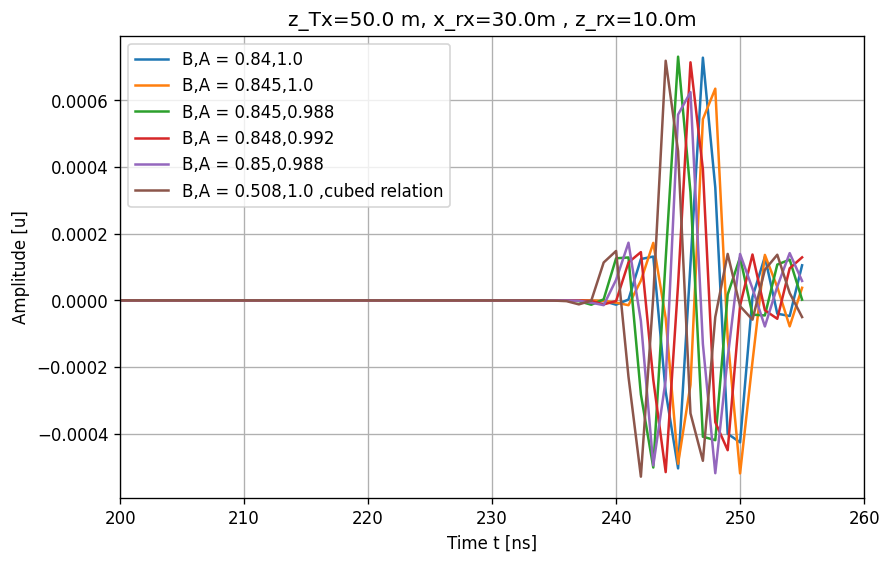

In [32]:
def cubedn(rho, A, B):
    return np.sqrt((A + B*rho)**3)
A1 = 1.0
A2 = .988
A3= .992

B1 = 0.840
B2 = 0.845
B3 = 0.850
B4 = .848
B5 = .508


z_vec = np.arange(0, iceDepth, dz)
rho_vec = np.interp(z_vec, z_vec0, rho_vec0)
n_vec1 = rho2refindex(rho_vec, A1, B1)
n_vec2 = rho2refindex(rho_vec, A1, B2)
n_vec3 = rho2refindex(rho_vec, A2, B2)
n_vec4 = rho2refindex(rho_vec, A3, B4)
n_vec5 = rho2refindex(rho_vec, A2, B3)
n_vec6 = cubedn(rho_vec, A1, B5)
n_vec_list = [n_vec1, n_vec2, n_vec3, n_vec4, n_vec5,n_vec6]
B_list = [B1, B2, B2, B4, B3, B5]
A_list = [A1,A1, A2,A3,A2, A1]
fig = plt.figure(figsize=(8,5),dpi=120)
ax = fig.add_subplot(111)
for i in range(len(n_vec_list)-1):
    n_vec = n_vec_list[i]
    sig_rx, t, spec_rx, f = get_rx_pulse(z_vec, n_vec, z_tx=sourceDepth2, x_rx=receiverRange[0], z_rx=receiverDepth0)
    ax.plot(t, sig_rx,label='B,A = ' + str(B_list[i]) +"," +str(A_list[i]))
n_vec = n_vec_list[5]
sig_rx, t, spec_rx, f = get_rx_pulse(z_vec, n_vec, z_tx=sourceDepth2, x_rx=receiverRange[0], z_rx=receiverDepth0)
ax.plot(t, sig_rx,label='B,A = ' + str(B_list[5]) +"," +str(A_list[5]) + " ,cubed relation")    

plt.title("z_Tx=" +str(sourceDepth2)+ " m, x_rx=" + str(receiverRange[0]) + "m , z_rx=" + str(receiverDepth0) +"m") 
#plt.xlim(200,260)
ax.legend()
ax.set_ylabel('Amplitude [u]')
ax.set_xlabel('Time t [ns]')
ax.grid()

plt.savefig("z_tx=50_x_rx=30_z_rx=10_zoomed.pdf")
plt.show()

In [ ]:
#label transmitter and reciver postions 
#zoom into pulse 
#plots for set of different positions. tx:(z): 10, 20, 50, rx:(x,z): (30,10) , (100,10) (30,20), (100,20) (30,50) (100,50) at different empirical relationships
#change ice depth to 60 m
#change ice length to 110 m